In [1]:
# ignore how many samples in ClaudinLow and Normal Like, but check how quickly it stops
# get sample numbers of inidividual cancer types after subsampling as check

In [33]:
df['Cancer Type'].values

array(['Normal', 'Basal', 'Her2', 'LumB', 'LumA', 'Luminal',
       'Claudin-low', 'ER+/HER2- High Prolif', 'ER-/HER2-',
       'ER+/HER2- Low Prolif', 'HER2+', 'IHC_HER2', 'IHC_ER', 'IHC_PR',
       'IHC_TNBC'], dtype=object)

In [61]:
import os
import sys
import settings
import numpy as np
import numpy.random as npr
import pandas as pd
import sys,os
import random
import copy
import json
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from utils.eval import find_best_matches, generate_exprs

from pathlib import Path
import multiprocessing as mp

from utils.eval import find_best_matches, make_known_groups, find_best_matching_biclusters

sns.set_theme(style="whitegrid")


def make_ref_groups(subtypes, annotation,exprs):
    # prepared a dict of subtype classifications {"class1":{"subt1":[],"subt2":[]},"class2":{"subtA":[],"subtB":[]}}
    all_samples = set(exprs.columns.values)
    pam50 = make_known_groups(subtypes, exprs,target_col = "PAM50",verbose=False)
    lum = {}
    lum["Luminal"] = pam50["LumA"].union(pam50["LumB"])
    scmod2 = make_known_groups(subtypes, exprs,target_col = 'SCMOD2',verbose=False)
    claudin = {} 
    claudin["Claudin-low"] = set(subtypes.loc[subtypes['claudin_low']==1,:].index.values).intersection(all_samples)
    
    ihc = {}
    for x in ["IHC_HER2","IHC_ER","IHC_PR"]:
        ihc[x] = set(annotation.loc[annotation[x]=="Positive",:].index.values)
    ihc["IHC_TNBC"] = set(annotation.loc[annotation["IHC_TNBC"]==1,:].index.values)
    
    known_groups = {"PAM50":pam50,"Luminal":lum,"Claudin-low":claudin,"SCMOD2":scmod2,"IHC":ihc}
    
    freqs = {}
    N = exprs.shape[1]
    for classification in known_groups.keys():
        for group in known_groups[classification].keys():
            n = len(known_groups[classification][group])
            freqs[group] = n/N
    return known_groups, freqs

def subsample(factor, subtypes_df, annotation_df, exprs_df, subtype_counts, seed):
    error_margin_samples = 3  # round(100*(1-factor))
    error_margin_samples_intrinsic = 3
    subsample_limit = 100000
    known_groups, freqs = make_ref_groups(subtypes_df, annotation_df, exprs_df)
    _subtype_counts = copy.deepcopy(subtype_counts)
    _subtype_counts_targets = copy.deepcopy({cancer_type: round(n*factor) for cancer_type, n in _subtype_counts.items()})
    assigned_cancer_types = {}
    for key in known_groups.keys():
        for cancer_type, samples in known_groups[key].items():
            for sample in samples:
                if sample in assigned_cancer_types:
                    assigned_cancer_types[sample].append(cancer_type)
                else:
                    assigned_cancer_types[sample] = [cancer_type]
    npr.seed(seed)
    print('random_state1', np.random.get_state()[1][0])
    for _ in range(subsample_limit):
        picked_sample = npr.choice(list(assigned_cancer_types.keys()))
        # test
        cancer_types = assigned_cancer_types[picked_sample]
        flag = True
        for cancer_type in cancer_types:
            n_new = _subtype_counts[cancer_type] - 1
            if n_new < _subtype_counts_targets[cancer_type] - error_margin_samples_intrinsic:
                flag = False
        if flag:
            # can be removed
            for cancer_type in cancer_types:
                _subtype_counts[cancer_type] -= 1
            del assigned_cancer_types[picked_sample]
            
            if sum(_subtype_counts.values()) in range(sum(_subtype_counts_targets.values())-error_margin_samples, sum(_subtype_counts_targets.values())+error_margin_samples):
                return list(assigned_cancer_types.keys())
    return []

def are_min_samples_in_cohorts(subtypes_df, annotation_df, exprs_df, min_samples):
    known_groups, freqs = make_ref_groups(subtypes_df, annotation_df, exprs_df)
    sizes = {}
    for key in known_groups.keys():
        for cancer_type, samples in known_groups[key].items():
            sizes[cancer_type] = len(samples)
        if any([len(values) < min_samples for key, values in known_groups[key].items() if key not in ['Normal', 'Claudin-low']]):
            return False
    return sizes


def read_dataset(dataset):
    subtypes_df = pd.read_csv(dataset['subtypes'],sep = "\t",index_col=0)
    annotation_df = pd.read_csv(dataset['annotation'],sep = "\t",index_col=0)
    exprs_df = pd.read_csv(dataset['expression'],sep = "\t",index_col=0)
    exprs_df[exprs_df>3] = 3
    exprs_df[exprs_df<-3] = -3
    return subtypes_df, annotation_df, exprs_df


def _create_subsampled_dataset(subtypes_df, annotation_df, exprs_df, factor=.5, subtype_counts={}, seed=None):
    # subsample samples
    samples = subsample(factor, subtypes_df, annotation_df, exprs_df, subtype_counts, seed)
    if not samples: 
        return [], False, False
    # subsample datasets
    subtypes_sub_df= subtypes_df[subtypes_df.index.isin(samples)]
    annotation_sub_df = annotation_df[annotation_df.index.isin(samples)]
    exprs_sub_df = exprs_df[samples]
    return subtypes_sub_df, annotation_sub_df, exprs_sub_df

def count_subtypes(known_groups):
    subtype_counts = {}
    for key in known_groups.keys():
        for cancer_type, samples in known_groups[key].items():
            subtype_counts[cancer_type] = len(samples)
    return subtype_counts

def subsample_dataset(subtypes_df, annotation_df, exprs_df, factor=.5, min_samples=10, limit=100, seed=None):
    if seed is not None:
        limit = 1
        npr.seed(seed)
    else:
        seed = npr.randint(1000000000)
    
    known_groups, freqs = make_ref_groups(subtypes_df, annotation_df, exprs_df)
    subtype_counts = count_subtypes(known_groups)
    
    for i in range(limit):
        subtypes_sub_df, annotation_sub_df, exprs_sub_df = _create_subsampled_dataset(subtypes_df, annotation_df, exprs_df, factor=factor, subtype_counts=subtype_counts, seed=seed)
        if len(subtypes_sub_df):
            # validate subsampled datasets
            sizes = are_min_samples_in_cohorts(subtypes_sub_df, annotation_sub_df, exprs_sub_df, min_samples)
            if sizes:
                return subtypes_sub_df, annotation_sub_df, exprs_sub_df, seed, sizes
        else:
#             print('Too little samples...')
            pass
        print('Less than min_samples...')
        seed = npr.randint(1000000000)
    raise Exception('Could not determine a subset of samples while subsampling. You can try to change the "min_samples" or the "factor". If you did that, try increasing the "limit".')
    
        
def run(dataset_name, seed=None, factor=settings.SUBSAMPLE_FACTOR, min_samples=settings.MIN_SAMPLES_PER_COHORT):
    dataset = settings.DATASETS[dataset_name]
    print(f'Reading dataset {dataset_name}...') 
    dfs = read_dataset(dataset)
    print(f'Subsampling {dataset_name}...') 
    subtypes_sub_df, annotation_sub_df, exprs_sub_df, seed, sizes = subsample_dataset(*dfs, factor=factor, min_samples=min_samples, limit=1000, seed=seed)
    print('Saving output...')
    output_path = os.path.join(
        settings.OUTPUT_FOLDER, 
        dataset_name, 
        f'seed={seed}',
        f'factor={factor}',
        f'min_samples={min_samples}'
    )
    output_path_subtype = os.path.join(output_path, settings.SUBSAMPLED_SUBTYPE_FILE)
    output_path_annotation = os.path.join(output_path, settings.SUBSAMPLED_ANNOTATION_FILE)
    output_path_exprs = os.path.join(output_path, settings.SUBSAMPLED_EXPRESSION_FILE)
    output_path_sizes = os.path.join(output_path, settings.SUBSAMPLED_SIZES_FILE)
    if not Path(output_path_sizes).is_file():
        folder = '/'.join(output_path_annotation.split('/')[:-1])
        Path(folder).mkdir(parents=True, exist_ok=True)
        subtypes_sub_df.to_csv(output_path_subtype, sep='\t')
        annotation_sub_df.to_csv(output_path_annotation, sep='\t')
        exprs_sub_df.to_csv(output_path_exprs, sep='\t')
        with open(output_path_sizes, 'w') as f:
            json.dump(sizes, f)
        print(f'Saved subsampled dataset for {dataset_name} and seed {seed} in "{folder}"!')
    else:
        print(f'FAILED: {output_path_annotation} already exists!')


In [62]:
np.random.get_state()[1][0]

3669219105

In [64]:
run('TCGA', seed=2147483648, factor=.05, min_samples=0)

Reading dataset TCGA...
Subsampling TCGA...
random_state1 2147483648
Saving output...
Saved subsampled dataset for TCGA and seed 2147483648 in "/local/DESMOND2_data/v6/preprocessed_v6/subsampled/TCGA/seed=2147483648/factor=0.05/min_samples=0"!


In [27]:
run('METABRIC', seed=394030538, factor=.1, min_samples=10)

Reading dataset METABRIC...
Subsampling METABRIC...
random_state1 394030538
Saving output...
Saved subsampled dataset for METABRIC and seed 394030538 in "/local/DESMOND2_data/v6/preprocessed_v6/subsampled/METABRIC/seed=394030538/factor=0.1/min_samples=10"!


In [69]:
seeds = [2147483648, 946911324, 59746734, 429310235, 999604441]

In [66]:
for seed in seeds:
    for factor in [.5, .4, .3, .2, .1, .05]:
        print(factor)
        run('METABRIC', seed=seed, factor=factor, min_samples=0)
        run('TCGA', seed=seed, factor=factor, min_samples=0)

0.05
Reading dataset METABRIC...
Subsampling METABRIC...
random_state1 2147483648
Saving output...
FAILED: /local/DESMOND2_data/v6/preprocessed_v6/subsampled/METABRIC/seed=2147483648/factor=0.05/min_samples=0/annotation.tsv already exists!
Reading dataset TCGA...
Subsampling TCGA...
random_state1 2147483648
Saving output...
FAILED: /local/DESMOND2_data/v6/preprocessed_v6/subsampled/TCGA/seed=2147483648/factor=0.05/min_samples=0/annotation.tsv already exists!
0.05
Reading dataset METABRIC...
Subsampling METABRIC...
random_state1 946911324
Saving output...
Saved subsampled dataset for METABRIC and seed 946911324 in "/local/DESMOND2_data/v6/preprocessed_v6/subsampled/METABRIC/seed=946911324/factor=0.05/min_samples=0"!
Reading dataset TCGA...
Subsampling TCGA...
random_state1 946911324
Saving output...
Saved subsampled dataset for TCGA and seed 946911324 in "/local/DESMOND2_data/v6/preprocessed_v6/subsampled/TCGA/seed=946911324/factor=0.05/min_samples=0"!
0.05
Reading dataset METABRIC...
S

In [20]:
subtype_counts_dataset = {}
datasets = ['METABRIC', 'TCGA']
for dataset_name in datasets:
    subtypes_df, annotation_df, exprs_df = read_dataset(settings.DATASETS[dataset_name])
    known_groups, freqs = make_ref_groups(subtypes_df, annotation_df, exprs_df)
    subtype_counts = count_subtypes(known_groups)
    subtype_counts_dataset[dataset_name] = subtype_counts

In [42]:
subtype_counts_dataset

{'METABRIC': {'Normal': 54,
  'Basal': 244,
  'Her2': 244,
  'LumB': 764,
  'LumA': 598,
  'Luminal': 1362,
  'Claudin-low': 86,
  'HER2+': 202,
  'ER-/HER2-': 365,
  'ER+/HER2- Low Prolif': 645,
  'ER+/HER2- High Prolif': 692,
  'IHC_HER2': 236,
  'IHC_ER': 1459,
  'IHC_PR': 1009,
  'IHC_TNBC': 299},
 'TCGA': {'Normal': 32,
  'Basal': 195,
  'Her2': 108,
  'LumB': 318,
  'LumA': 426,
  'Luminal': 744,
  'Claudin-low': 45,
  'HER2+': 96,
  'ER-/HER2-': 218,
  'ER+/HER2- Low Prolif': 360,
  'ER+/HER2- High Prolif': 405,
  'IHC_HER2': 156,
  'IHC_ER': 780,
  'IHC_PR': 673,
  'IHC_TNBC': 114}}

/local/DESMOND2_data/v6/preprocessed_v6/subsampled/METABRIC/seed=59746734/factor=0.5/min_samples=10/sizes.json
/local/DESMOND2_data/v6/preprocessed_v6/subsampled/METABRIC/seed=59746734/factor=0.4/min_samples=10/sizes.json
/local/DESMOND2_data/v6/preprocessed_v6/subsampled/METABRIC/seed=59746734/factor=0.3/min_samples=10/sizes.json
/local/DESMOND2_data/v6/preprocessed_v6/subsampled/METABRIC/seed=59746734/factor=0.2/min_samples=10/sizes.json
/local/DESMOND2_data/v6/preprocessed_v6/subsampled/METABRIC/seed=59746734/factor=0.1/min_samples=10/sizes.json
/local/DESMOND2_data/v6/preprocessed_v6/subsampled/METABRIC/seed=59746734/factor=0.05/min_samples=0/sizes.json
/local/DESMOND2_data/v6/preprocessed_v6/subsampled/TCGA/seed=59746734/factor=0.5/min_samples=10/sizes.json
/local/DESMOND2_data/v6/preprocessed_v6/subsampled/TCGA/seed=59746734/factor=0.4/min_samples=10/sizes.json
/local/DESMOND2_data/v6/preprocessed_v6/subsampled/TCGA/seed=59746734/factor=0.3/min_samples=10/sizes.json
/local/DESMON

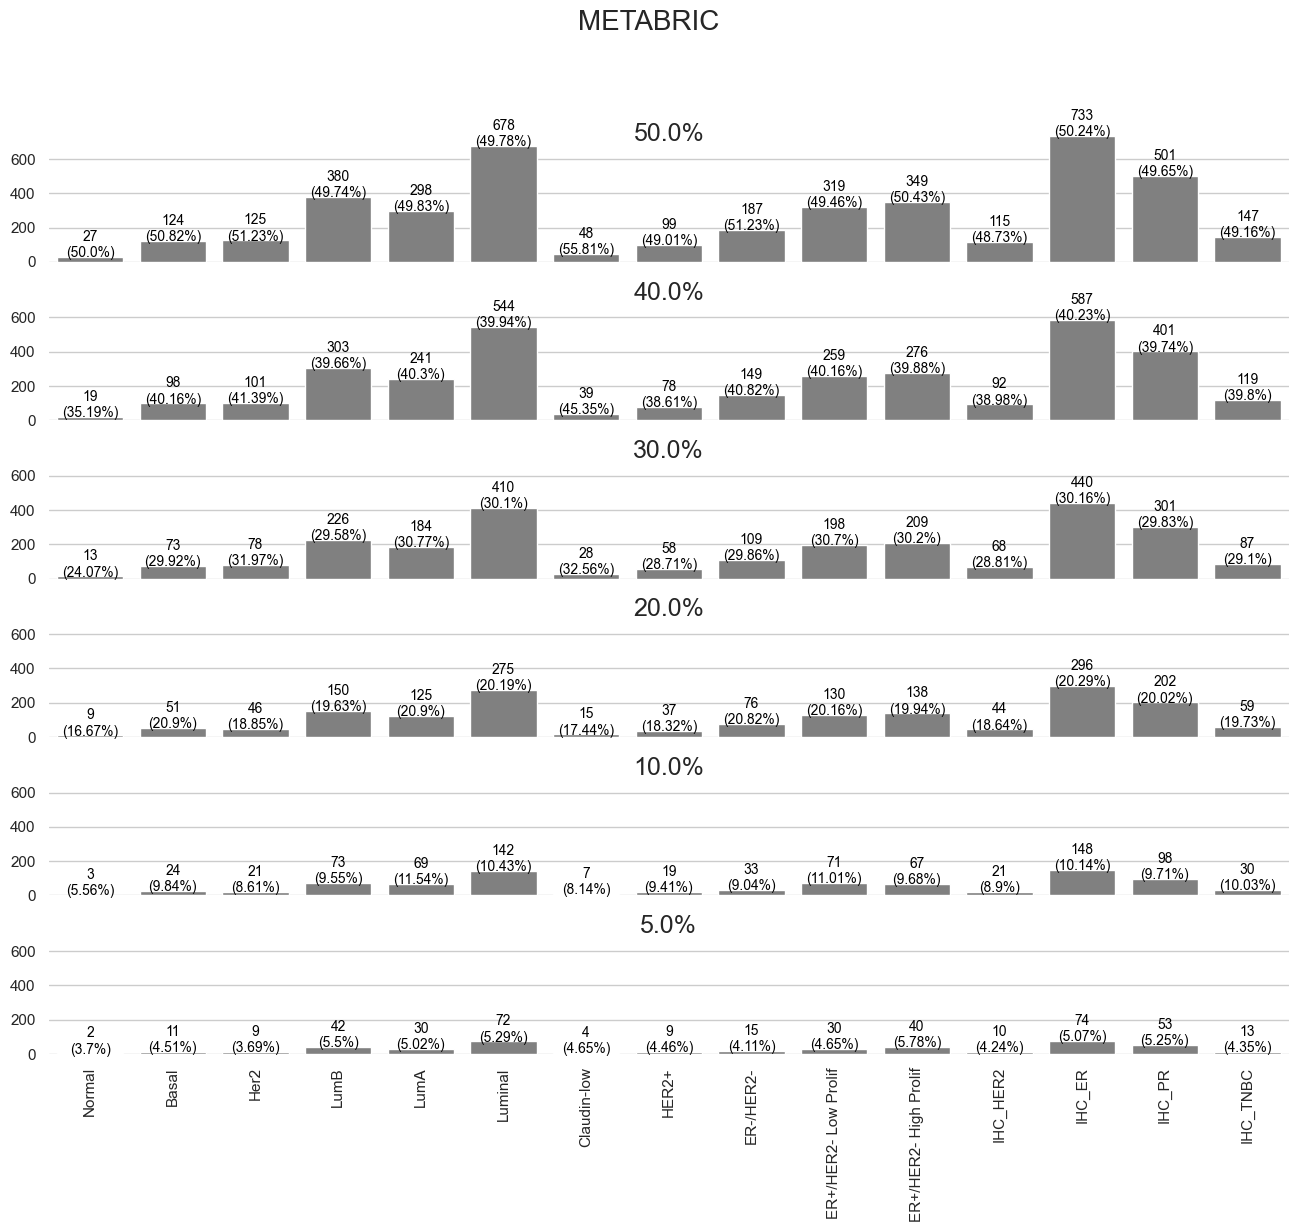

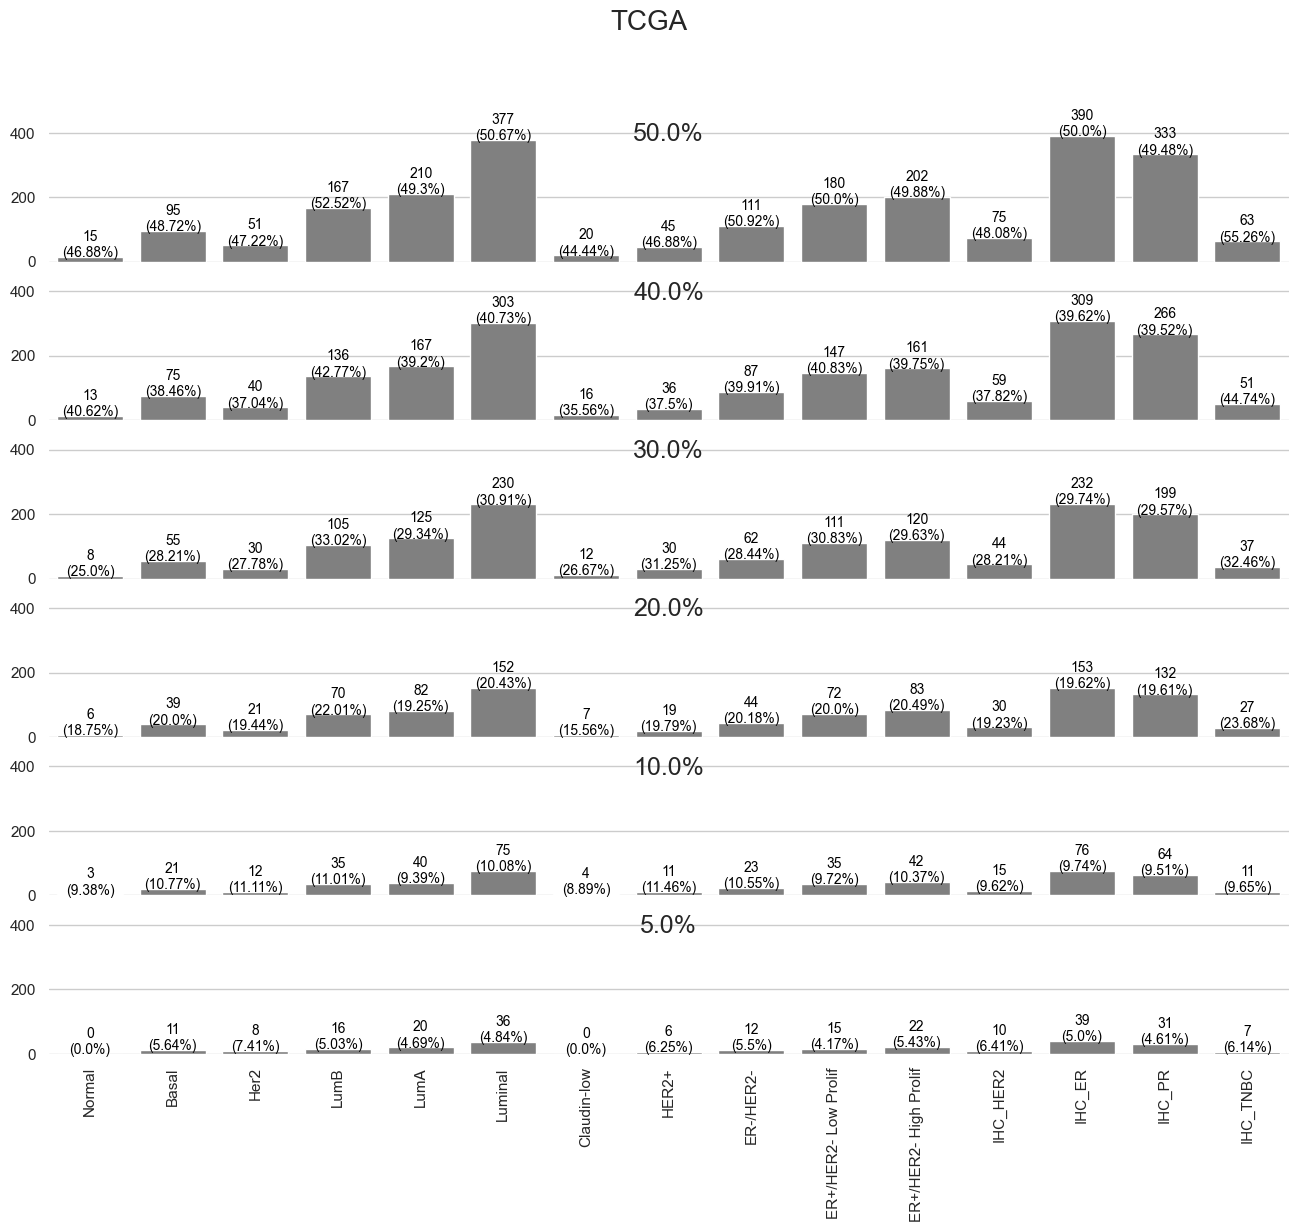

In [110]:
for seed in [59746734]:
    for dataset_name in datasets:
        for min_samples in ['10']:
            fig, axs = plt.subplots(6, 1, sharex=True, sharey=True, figsize=(16, 12))
    #         plt.subplots_adjust(hspace=0)
            for i, factor in enumerate([.5, .4, .3, .2, .1, .05]):
                
                if factor > 0.05:
                    min_samples = '10'
                else:
                    min_samples = '0'
                    
                path_sizes = os.path.join(
                    settings.OUTPUT_FOLDER, 
                    dataset_name, 
                    f'seed={seed}',
                    f'factor={factor}',
                    f'min_samples={min_samples}', 
                    settings.SUBSAMPLED_SIZES_FILE)

                with open(path_sizes) as f:
                    d = json.loads(f.read())
                    df = pd.DataFrame(d.items(), columns=['Cancer Type', 'Count'])
                    
                    for cancer_type in subtype_counts_dataset[dataset_name].keys():
                        if cancer_type not in df['Cancer Type'].values:
                            print(cancer_type)
                            df = pd.concat([df, pd.DataFrame({'Cancer Type': cancer_type, 'Count': 0}, index=[0])], ignore_index=True)
                    df = df.set_index('Cancer Type').T[subtype_counts_dataset[dataset_name].keys()].T.reset_index()
    #                 df['Cancer Type'] = df['Cancer Type'].map(lambda x: x.replace('_', ' '))
                    ax = sns.barplot(data=df, x='Cancer Type', y='Count', facecolor='grey', ax=axs[i], order=subtype_counts_dataset[dataset_name].keys())
                    for index, row in df.iterrows():
                        count_complete = subtype_counts_dataset[dataset_name][row['Cancer Type']]
                        ax.text(index, row['Count'], f"{row['Count']}\n({round(row['Count']/count_complete*100, 2)}%)", color='black', ha="center", rotation=0, fontsize=10)
                    ax.tick_params(axis='x', rotation=90)
                    ax.set(xlabel=None, ylabel=None)
                    ax.set_title(f'{factor*100}%', fontsize=18, y=1.0, pad=-8) # pad=-8
                    sns.despine(bottom = True, left = True, right=True, top=True)
                    print(path_sizes)

            fig.suptitle(dataset_name, fontsize=20)
            plt.savefig(f'counts_subsampled_{dataset_name}_seed={seed}.png', dpi=300)

        

In [95]:
'Normal'  in df['Cancer Type'].values

True

,Cancer Type,Count
0,Normal,0
1,Basal,11
2,Her2,8
3,LumB,16
4,LumA,20
5,Luminal,36
6,Claudin-low,0
7,HER2+,6
8,ER-/HER2-,12
9,ER+/HER2- Low Prolif,15


In [109]:
df.iloc[:]

,Cancer Type,Count
0,LumA,20
1,Her2,8
2,LumB,16
3,Basal,11
4,Luminal,36
5,Claudin-low,0
6,HER2+,6
7,ER-/HER2-,12
8,ER+/HER2- Low Prolif,15
9,ER+/HER2- High Prolif,22


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'LumB'),
  Text(1, 0, 'LumA'),
  Text(2, 0, 'Normal'),
  Text(3, 0, 'Basal'),
  Text(4, 0, 'Her2'),
  Text(5, 0, 'Luminal'),
  Text(6, 0, 'Claudin-low'),
  Text(7, 0, 'ER+/HER2- Low Prolif'),
  Text(8, 0, 'ER-/HER2-'),
  Text(9, 0, 'HER2+'),
  Text(10, 0, 'ER+/HER2- High Prolif'),
  Text(11, 0, 'IHC HER2'),
  Text(12, 0, 'IHC ER'),
  Text(13, 0, 'IHC PR'),
  Text(14, 0, 'IHC TNBC')])

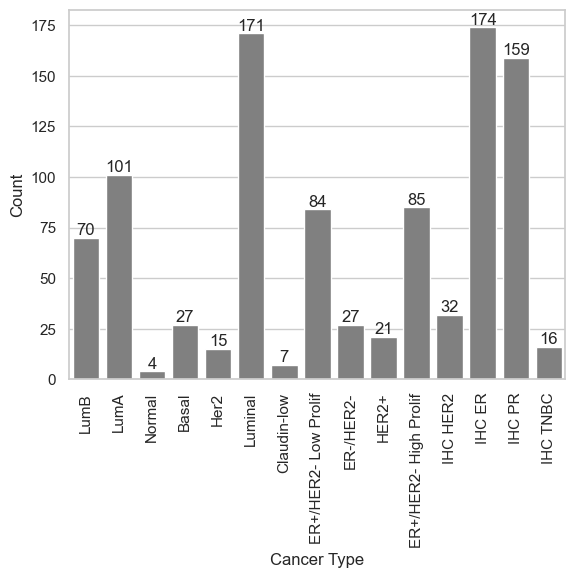